In [10]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 
from scipy import stats 
from windrose import WindroseAxes

In [11]:
df = pd.read_csv("../src/data/sierraleone-bumbuna.csv")

Statical summary 

In [ ]:
# print(df.describe()) # for numerical date mean, std, maz, min..

# df.describe(include=['object']) # for categorical column 

# print(df.isna()) # presents nan value as true and false for non-nan 

# print(df.info())
# print(df.sum())
# print(df.isna().sum())
# print(df[['GHI', 'DNI', 'DHI']].isna().sum()) # check nan value for specific columns 
print((df[['GHI', 'DNI', 'DHI']] < 0).sum())#check for negative values as radiation can't be negative 


# Column to check
numeric_cols = df.select_dtypes(include='number').columns

# Plot histogram
df[numeric_cols].hist(bins=50, figsize=(16, 12), color='skyblue', edgecolor='black')
plt.suptitle('Histograms of All Numeric Columns', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


Outlier Detection & Basic Cleaning

In [ ]:
# Define the columns to check for outliers
columns_to_check = ['GHI', 'DNI', 'DHI','ModA', 'ModB', 'WS', 'WSgust']

# Function to detect outliers using IQR
def detect_outliers_iqr(df, columns):
    outlier_counts = {}
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 3 * IQR
        upper_bound = Q3 + 3 * IQR

        # Find outliers
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outlier_counts[col] = len(outliers)

        print(f"\n📊 Column: {col}")
        print(f" - Q1: {Q1:.2f}")
        print(f" - Q3: {Q3:.2f}")
        print(f" - IQR: {IQR:.2f}")
        print(f" - Lower Bound: {lower_bound:.2f}")
        print(f" - Upper Bound: {upper_bound:.2f}")
        print(f" - Outliers found: {len(outliers)}")

    return outlier_counts

# Call  function
outlier_summary = detect_outliers_iqr(df, columns_to_check)

# Boxplot Visualization
for col in columns_to_check:
    plt.figure(figsize=(8, 1.5))  # Wide and short for horizontal boxplot
    sns.boxplot(x=df[col], color="skyblue")
    plt.title(f"Boxplot of {col}")
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()

Z-scores detection & Impute with median for outliers 

In [12]:
# Columns to analyze
columns_to_check = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']

# Replace negative values in radiation columns with NaN
radiation_columns = ['GHI', 'DNI', 'DHI']
for col in radiation_columns:
    df[col] = df[col].mask(df[col] < 0, np.nan)

# Impute negative/NaN values in radiation columns with median
for col in radiation_columns:
    median_val = df[col].median()
    df[col] = df[col].fillna(median_val)

#  Compute Z-scores for all target columns
z_scores = stats.zscore(df[columns_to_check], nan_policy='omit')  # Handles NaN gracefully
z_scores_df = pd.DataFrame(z_scores, columns=columns_to_check)

#  Identify outliers where |Z| > 3
z_outliers = (np.abs(z_scores_df) > 3)

#  Add a flag column for rows with any Z-score outlier
df['Z_Outlier_Flag'] = z_outliers.any(axis=1)

# Preview flagged rows
outlier_rows = df[df['Z_Outlier_Flag']]
print(f"\n🚩 Rows with Z-score > 3 in any target column: {len(outlier_rows)}")
print(outlier_rows[columns_to_check + ['Z_Outlier_Flag']].head())

#  Replace Z-score outliers with NaN
for col in columns_to_check:
    df[col] = df[col].mask(z_outliers[col], np.nan)

# Impute NaNs (from outliers) with column median
for col in columns_to_check:
    median_val = df[col].median()
    df[col] = df[col].fillna(median_val)

# ✅ Final confirmation
print("\n✅ After cleaning and imputing:")
print(df[columns_to_check].describe())
print(df[columns_to_check].head())


🚩 Rows with Z-score > 3 in any target column: 22124
       GHI   DNI    DHI   ModA   ModB   WS  WSgust  Z_Outlier_Flag
630  564.6  22.2  546.5  585.4  570.6  0.0     0.7            True
631  579.9  34.7  551.8  602.6  587.4  0.1     0.7            True
632  600.3  55.7  555.5  627.5  611.9  0.0     0.0            True
633  608.0  67.3  552.6  633.2  617.6  0.0     0.0            True
650  631.0  92.2  552.4  672.4  656.7  0.4     1.9            True

✅ After cleaning and imputing:
                 GHI            DNI            DHI           ModA  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      376.155999     162.744336     224.380174     203.053701   
std       205.874659     173.982181      97.033596     296.231357   
min         0.000000       0.000000       0.000000       0.000000   
25%       356.700000     115.300000     225.000000       0.000000   
50%       359.500000     115.300000     225.000000       3.200000   
75%       359.500000     115.3

In [13]:
output_file_path = "../src/data/sierraleone_cleaned_data.csv" # save cleaned data 
df.to_csv(output_file_path, index=False)  

print(f"\n📂 Cleaned dataset saved to: {output_file_path}")


📂 Cleaned dataset saved to: ../src/data/sierraleone_cleaned_data.csv


Time Series Analysis

C:\Users\mijuu\AppData\Local\Temp\ipykernel_9692\1457548072.py:23: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\mijuu\AppData\Local\Temp\ipykernel_9692\1457548072.py:29: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.savefig(filename, dpi=300)
c:\Users\mijuu\Documents\solar-challenge-week1\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


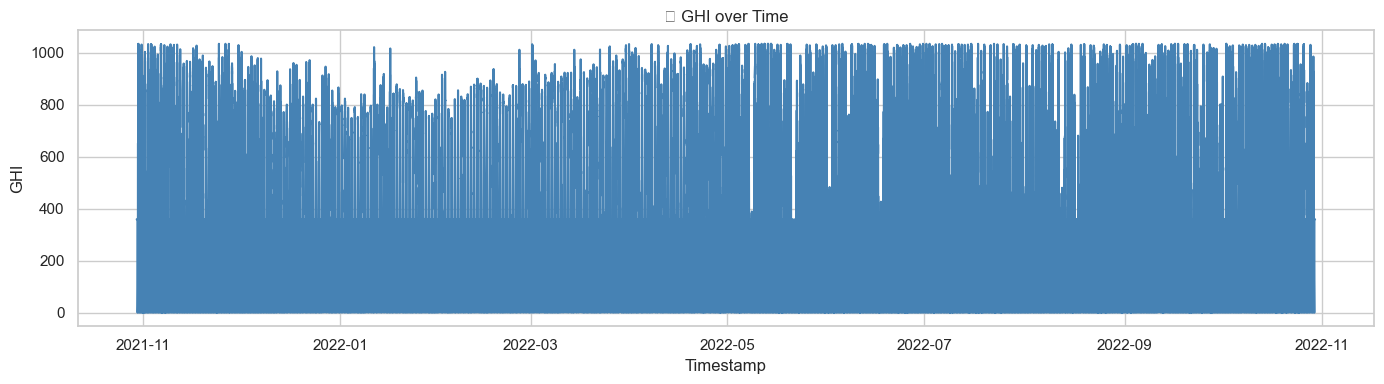

✅ Saved: ../images/sierraleone/GHI_time_series.png


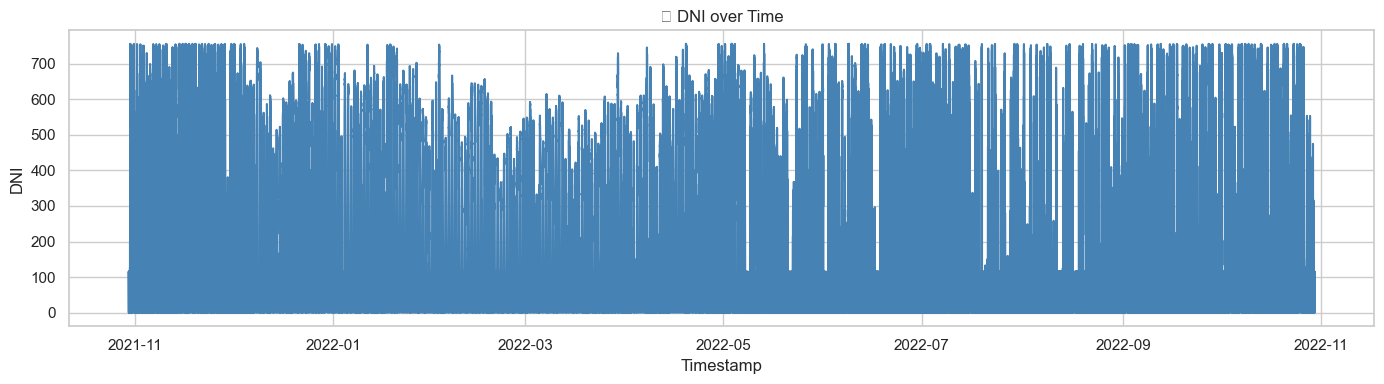

✅ Saved: ../images/sierraleone/DNI_time_series.png


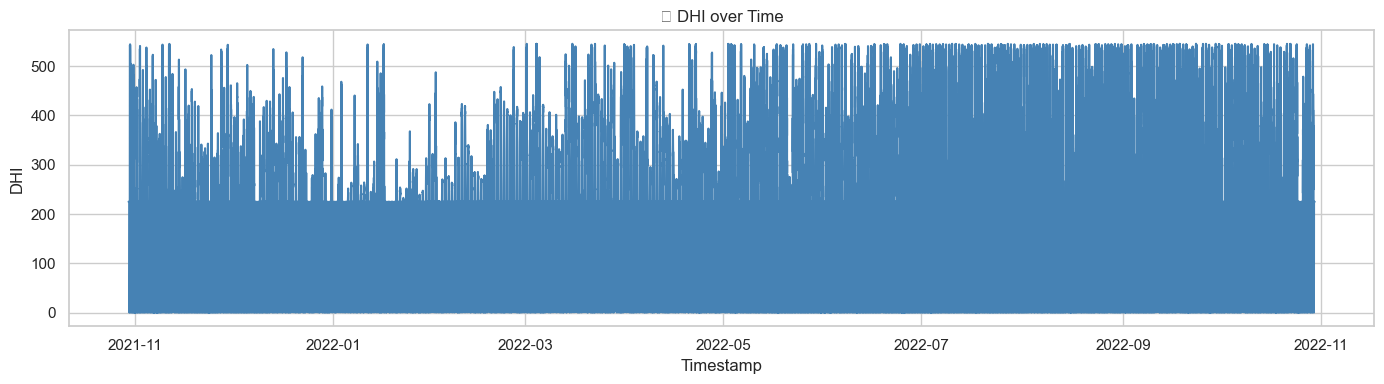

✅ Saved: ../images/sierraleone/DHI_time_series.png


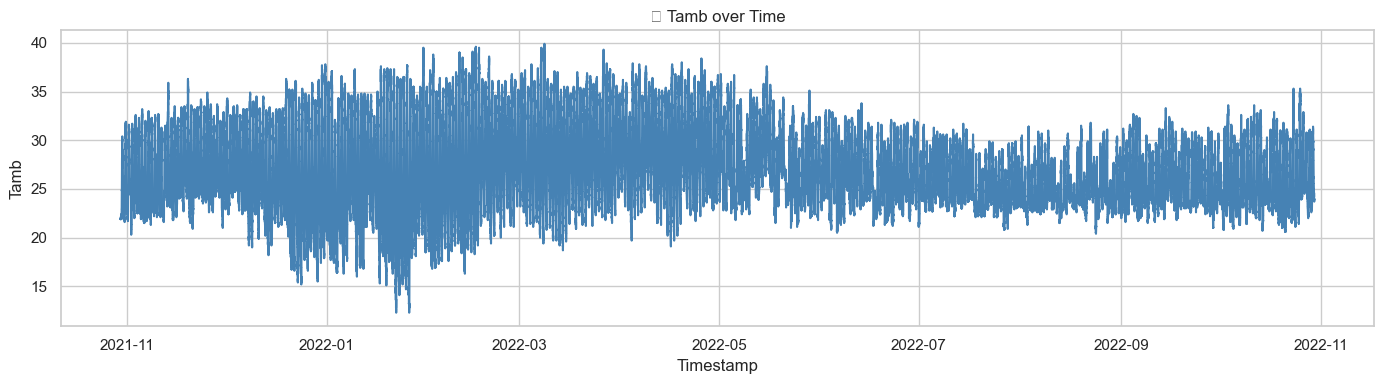

✅ Saved: ../images/sierraleone/Tamb_time_series.png


In [14]:

# Ensure Timestamp is in datetime format
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Set Timestamp as the index for time series plotting
df.set_index('Timestamp', inplace=True)

# List of columns to plot
columns_to_plot = ['GHI', 'DNI', 'DHI', 'Tamb']

# Set plot style
sns.set(style="whitegrid")

# Folder name to save image 
folder_path = '../images/sierraleone/' 

# Plot each column in a separate figure
for col in columns_to_plot:
    plt.figure(figsize=(14, 4))
    plt.plot(df.index, df[col], label=col, color='steelblue')
    plt.title(f'📈 {col} over Time')
    plt.xlabel('Timestamp')
    plt.ylabel(col)
    plt.tight_layout()
    plt.grid(True)
   

    # Save plot as PNG file
    filename = f"{folder_path}{col}_time_series.png"
    plt.savefig(filename, dpi=300)  
    plt.show()

    print(f"✅ Saved: {filename}")

 

C:\Users\mijuu\AppData\Local\Temp\ipykernel_9692\3027414917.py:14: UserWarning: Glyph 128198 (\N{TEAR-OFF CALENDAR}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\mijuu\Documents\solar-challenge-week1\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128198 (\N{TEAR-OFF CALENDAR}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


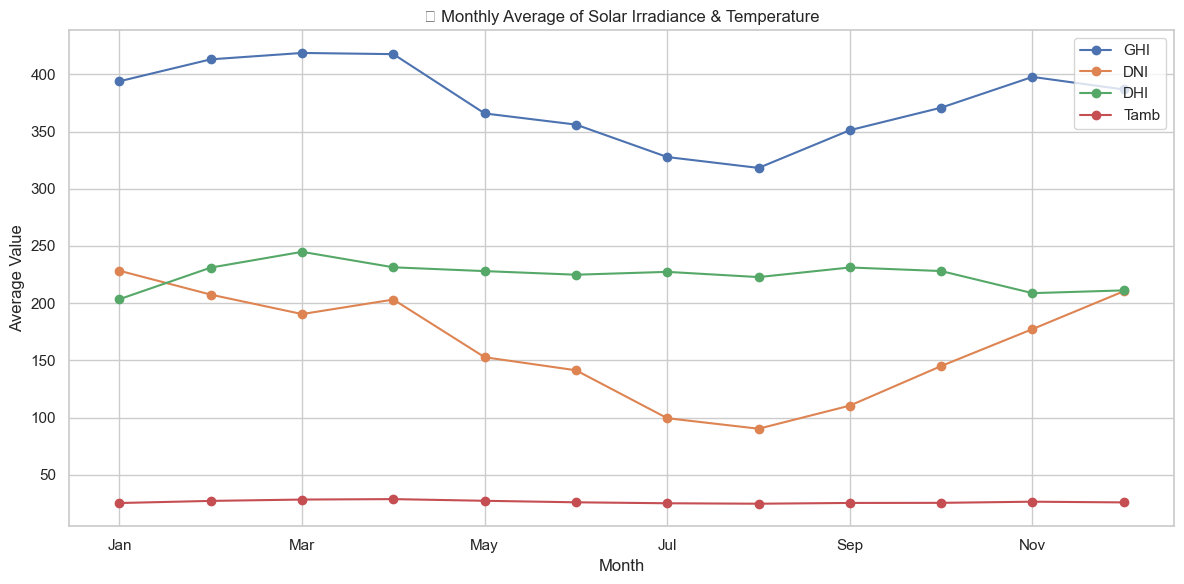

✅ Saved: ../images/sierraleone/monthly_avg_irradiance_temp.png


In [17]:
# Group by month from Timestamp index
monthly_avg = df.groupby(df.index.month)[['GHI', 'DNI', 'DHI', 'Tamb']].mean()

# Rename month numbers to names
monthly_avg.index = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                     'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Plot
monthly_avg.plot(figsize=(12, 6), marker='o')
plt.title('📆 Monthly Average of Solar Irradiance & Temperature')
plt.xlabel('Month')
plt.ylabel('Average Value')
plt.grid(True)
plt.tight_layout()
plt.show()

# ✅ Save plot as PNG
output_path = "../images/sierraleone/monthly_avg_irradiance_temp.png"
plt.savefig(output_path, dpi=300)
plt.close()

print(f"✅ Saved: {output_path}")

In [ ]:
# Group by hour of the day from Timestamp
hourly_avg = df.groupby(df.index.hour)[['GHI', 'DNI', 'DHI', 'Tamb']].mean()

# Plot
hourly_avg.plot(figsize=(12, 6), marker='o')
plt.title('🕒 Hourly Average of Solar Irradiance & Temperature')
plt.xlabel('Hour of Day')
plt.ylabel('Average Value')
plt.grid(True)
plt.tight_layout()
plt.show()

Cleaning impact 

In [ ]:
# Group by Cleaning flag and compute mean of ModA and ModB
mod_avg_by_cleaning = df.groupby('Cleaning')[['ModA', 'ModB']].mean()

# Plotting
mod_avg_by_cleaning.plot(kind='bar', figsize=(8, 5), rot=0)
plt.title('🔧 Average ModA and ModB - Pre vs Post Cleaning')
plt.xlabel('Cleaning Flag (0 = Before, 1 = After)')
plt.ylabel('Average Sensor Output')
plt.legend(title='Sensor')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

Correlation & Relationship Analysis

In [ ]:
# Select relevant columns
columns = ['GHI', 'DNI', 'DHI', 'TModA', 'TModB']
corr_matrix = df[columns].corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=0.5)
plt.title("🔍 Correlation Heatmap of Solar & Module Temperatures")
plt.tight_layout()
plt.show()

In [ ]:
# Set style
sns.set(style="whitegrid")

# Define pairs to plot
scatter_pairs = [
    ('WS', 'GHI'),    # Wind speed effect on irradiance
    ('WSgust', 'GHI'), # Gusty wind and cloud movement
    ('WD', 'GHI'), # Wind direction’s influence
    ('RH', 'Tamb'), #Humidity vs. temperature
    ('RH', 'GHI') # Humidity vs. solar availability
]

# Plot each scatter pair
for x_var, y_var in scatter_pairs:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(data=df, x=x_var, y=y_var, alpha=0.4, color='teal')
    plt.title(f'📈 {y_var} vs. {x_var}')
    plt.xlabel(x_var)
    plt.ylabel(y_var)
    plt.tight_layout()
    plt.show()

Wind & Distribution Analysis

In [ ]:
# Clean any missing values for WS or WD
df_clean = df[['WS', 'WD']].dropna()

# Create Windrose plot
ax = WindroseAxes.from_ax()
ax.bar(df_clean['WD'], df_clean['WS'], normed=True, opening=0.8, edgecolor='white')
ax.set_title('🧭 Wind Rose: Wind Speed vs. Wind Direction')
ax.set_legend()
plt.show()

Temperature Analysis

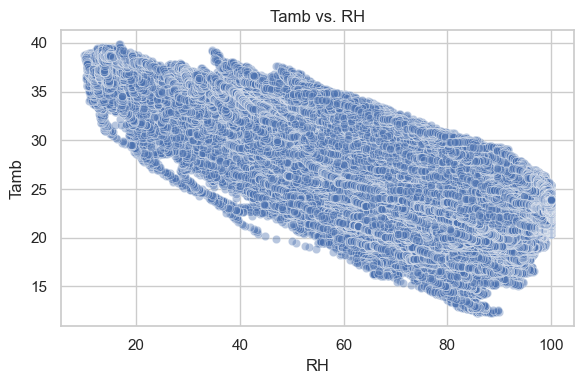

✅ Saved: ../images/sierraleone/Tamb_vs_RH_scatter.png


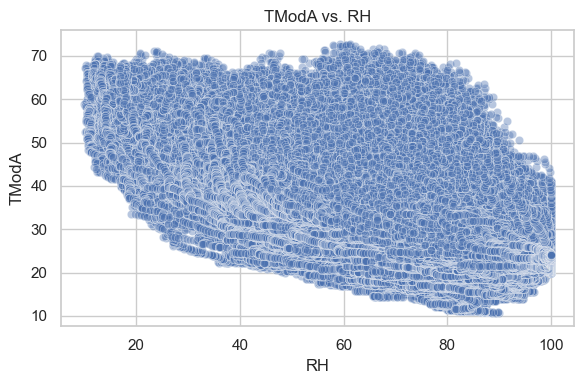

✅ Saved: ../images/sierraleone/TModA_vs_RH_scatter.png


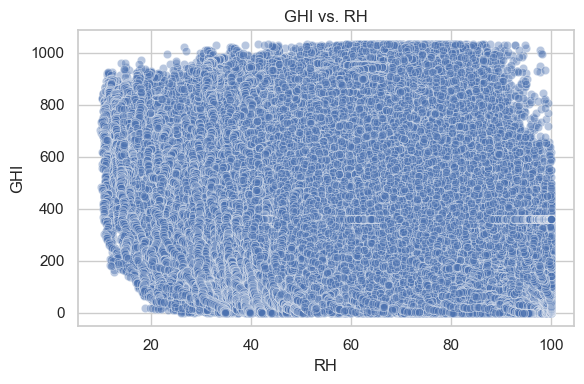

✅ Saved: ../images/sierraleone/GHI_vs_RH_scatter.png


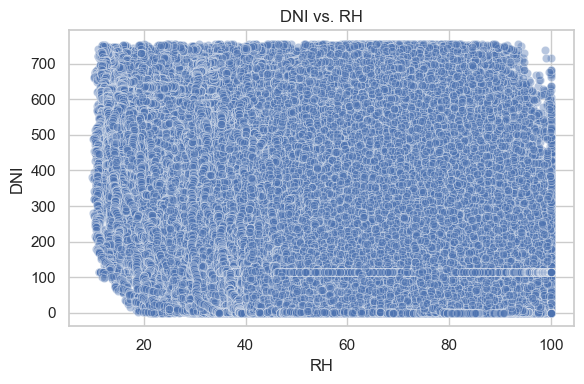

✅ Saved: ../images/sierraleone/DNI_vs_RH_scatter.png


In [ ]:
scatter_pairs = [
    ('RH', 'Tamb'),
    ('RH', 'TModA'),
    ('RH', 'GHI'),
    ('RH', 'DNI')
]
folder_path = '../images/sierraleone/' 

for x, y in scatter_pairs:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(data=df, x=x, y=y, alpha=0.4)
    plt.title(f'{y} vs. {x}')
    plt.xlabel(x)
    plt.ylabel(y)
    plt.tight_layout()

    # Save plot as PNG file
    filename = f"{folder_path}{y}_vs_{x}_scatter.png"
    plt.savefig(filename, dpi=300)
    plt.show()

    print(f"✅ Saved: {filename}")

# Finding : higher Ambient Temperature is associated with lower Relative Humidity

Bubble Chart

C:\Users\mijuu\AppData\Local\Temp\ipykernel_9692\3402267686.py:13: UserWarning: Glyph 127777 (\N{THERMOMETER}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\mijuu\AppData\Local\Temp\ipykernel_9692\3402267686.py:13: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\mijuu\AppData\Local\Temp\ipykernel_9692\3402267686.py:17: UserWarning: Glyph 127777 (\N{THERMOMETER}) missing from font(s) Arial.
  plt.savefig(filename, dpi=300)
C:\Users\mijuu\AppData\Local\Temp\ipykernel_9692\3402267686.py:17: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.savefig(filename, dpi=300)
c:\Users\mijuu\Documents\solar-challenge-week1\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127777 (\N{THERMOMETER}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\mijuu\Documents\solar-challenge-week1\.venv\Lib\site-packages\IPython\core\pylabtools.py:170

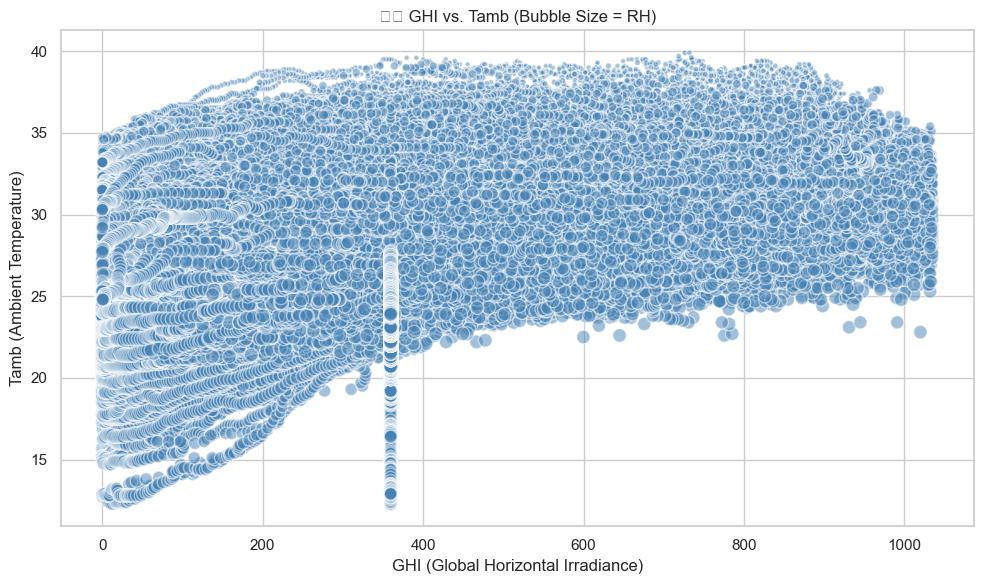

In [ ]:
df_bubble = df[['GHI', 'Tamb', 'RH']].dropna()

# Create the bubble chart
plt.figure(figsize=(10, 6))
plt.scatter(df_bubble['GHI'], df_bubble['Tamb'], 
            s=df_bubble['RH'],  # bubble size
            alpha=0.5, c='steelblue', edgecolors='w')

plt.title('🌡️ GHI vs. Tamb (Bubble Size = RH)')
plt.xlabel('GHI (Global Horizontal Irradiance)')
plt.ylabel('Tamb (Ambient Temperature)')
plt.grid(True)
plt.tight_layout()

# Save the figure
filename = f"{folder_path}GHI_vs_Tamb_bubble.png"
plt.savefig(filename, dpi=300)
plt.show()

# Finding: Relative humidity is highest when GHI and Tamb are moderate.
